__With what error rate can we predict the logc5 considering only title length?__

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.insert(0, "../code-previous")
sys.path.insert(0, "..")

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

In [3]:
import pandas as pd
import numpy as np
import nltk
stopwords = nltk.corpus.stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
path2rawdata = '/mnt/disks/vault/wos2017-parsed/'

In [4]:
raw_data_path = "/mnt/disks/vault/analysis-data/raw_data_full/raw_data_full.pql"
data = pd.read_pickle(raw_data_path)

data = data[data.Journal == "APPLIED PHYSICS LETTERS"]

In [5]:
# filtering the data on which the model could be fit well
data = data[data.PubYear_x.isin([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
len(data)

41100

In [6]:
# what is the average number of words per year
# New fields to dataframe 
data['log_c5'] = data['c5'].progress_apply(lambda x: np.log(x+1))
data['character_count'] = data['Title'].progress_apply(lambda x: len(x))
data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data['title_without_punct'] = data['Title'].progress_apply(lambda x: 
                                                           str.lower(''.join(ch for ch in str(x) if category(ch)[0] != 'P')))
data["title_without_stopwords"] = data['title_without_punct'].progress_apply(lambda x: 
                                                                            " ".join([word for word in x.split() if word not in stopwords]))


data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data["cleaned_title_word_count"] = data["title_without_stopwords"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 41100/41100 [00:00<00:00, 531715.52it/s]


In [7]:
def get_grouped_data_for_year(year):
    tmp = data[data.PubYear_x == year]
    tmp = tmp.groupby('word_count')['c5'].mean().reset_index(name="avg_c5")
    tmp['avg_log_c5'] = tmp['avg_c5'].apply(lambda x: np.log(x))
    return tmp
    
grouped_avgs = [get_grouped_data_for_year(year) for year in range(2002, 2011)]

In [8]:
x02 = list(grouped_avgs[0]["word_count"])
y02 = list(grouped_avgs[0]["avg_log_c5"])
x03 = list(grouped_avgs[1]["word_count"])
y03 = list(grouped_avgs[1]["avg_log_c5"])
x04 = list(grouped_avgs[2]["word_count"])
y04 = list(grouped_avgs[2]["avg_log_c5"])
x05 = list(grouped_avgs[3]["word_count"])
y05 = list(grouped_avgs[3]["avg_log_c5"])
x06 = list(grouped_avgs[4]["word_count"])
y06 = list(grouped_avgs[4]["avg_log_c5"])
x07 = list(grouped_avgs[5]["word_count"])
y07 = list(grouped_avgs[5]["avg_log_c5"])
x08 = list(grouped_avgs[6]["word_count"])
y08 = list(grouped_avgs[6]["avg_log_c5"])
x09 = list(grouped_avgs[7]["word_count"])
y09 = list(grouped_avgs[7]["avg_log_c5"])
x10 = list(grouped_avgs[8]["word_count"])
y10 = list(grouped_avgs[8]["avg_log_c5"])

In [9]:
X_ = [x02 + x03 + x04 + x05 + x06 + x07 + x08 + x09 + x10]
y_ = [y02 + y03 + y04 + y05 + y06 + y07 + y08 + y09 + y10]

X = pd.DataFrame([item for sublist in X_ for item in sublist], columns=["word_count"])
y = pd.DataFrame([item for sublist in y_ for item in sublist], columns=["avg_log_c5"])

df = pd.concat([X, y], axis=1)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

X_train, X_test, y_train, y_test = train_test_split(df[["word_count"]], df["avg_log_c5"], test_size=0.2)

In [10]:
# fit a model
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

# Error in prediction
rmse = mean_squared_error(y_test, y_pred)
print("Error: ", rmse)
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", rmse)

# slope
slope = lm.coef_[0]
print("Slope:", lm.coef_[0])

# y - intercept
intercept = lm.intercept_
print("Intercept:", lm.intercept_)

Error:  0.27865424369102265
R2 Score:  0.27865424369102265
Slope: -0.04043146878439648
Intercept: 3.1821470529336207


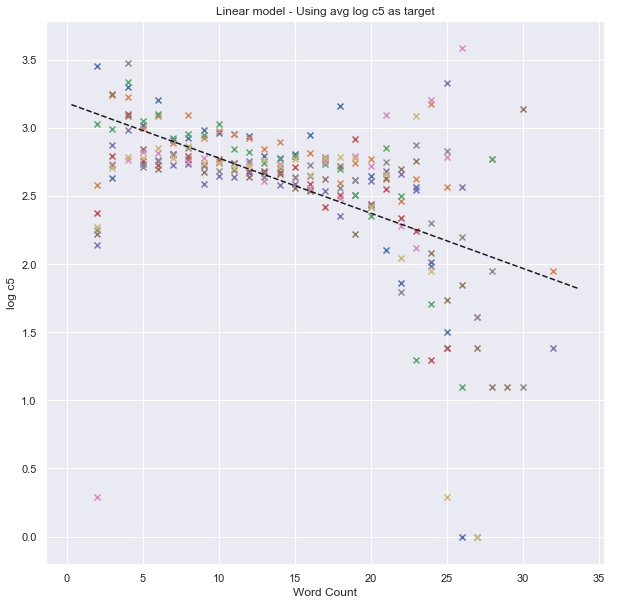

In [11]:
f = plt.figure(figsize=(10,10))
plt.scatter(x02, y02, marker="x")
plt.scatter(x03, y03, marker="x")
plt.scatter(x04, y04, marker="x")
plt.scatter(x05, y05, marker="x")
plt.scatter(x06, y06, marker="x")
plt.scatter(x07, y07, marker="x")
plt.scatter(x08, y08, marker="x")
plt.scatter(x09, y09, marker="x")
plt.scatter(x10, y10, marker="x")

plt.xlabel("Word Count")
plt.ylabel("log c5")



axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
plt.title("Linear model - Using avg log c5 as target")

plt.show()

Text(0.5,1,'2010 - Slope: -0.041')

<Figure size 432x288 with 0 Axes>

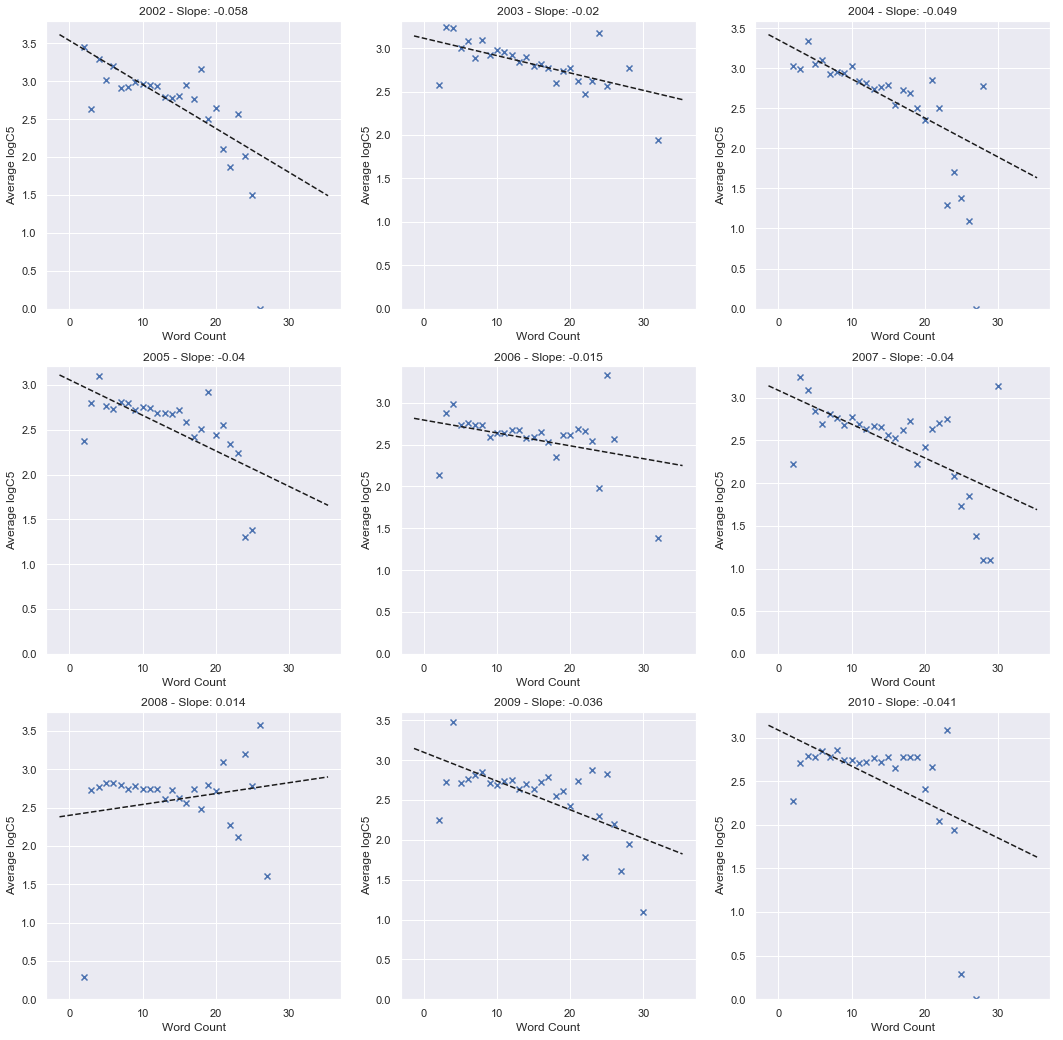

In [12]:
X_years = [x02, x03, x04, x05, x06, x07, x08, x09, x10]
y_years = [y02, y03, y04, y05, y06, y07, y08, y09, y10] 


def get_data_for_year(idx):
    X = pd.DataFrame(X_years[idx], columns=["word_count"])
    y = pd.DataFrame(y_years[idx], columns=["avg_log_c5"])
    
    df = pd.concat([X, y], axis=1)
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    return df

def get_model_params(df):
    X_train, X_test, y_train, y_test = train_test_split(df[["word_count"]], df["avg_log_c5"], test_size=0.1)
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)
    intercept = lm.intercept_
    slope = lm.coef_[0]

    return intercept, slope
    

# Average character, word and cleaned title word counts over the years
f1 = plt.figure()
f1 = plt.figure(figsize=(18,18))


ax1 = f1.add_subplot(331)

tmp = get_data_for_year(0)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2002 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(332)
tmp = get_data_for_year(1)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2003 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(333)
tmp = get_data_for_year(2)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2004 - Slope: " + str(np.round(slope, 3)))



ax1 = f1.add_subplot(334)
tmp = get_data_for_year(3)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2005 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(335)
tmp = get_data_for_year(4)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2006 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(336)
tmp = get_data_for_year(5)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2007 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(337)
tmp = get_data_for_year(6)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2008 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(338)
tmp = get_data_for_year(7)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2009 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(339)
tmp = get_data_for_year(8)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")
ax1.set_title("2010 - Slope: " + str(np.round(slope, 3)))

In [13]:
def get_grouped_data_for_year(year):
    tmp = data[data.PubYear_x == year]
    tmp = tmp.groupby('word_count')['c5'].median().reset_index(name="median_c5")
    tmp['median_log_c5'] = tmp['median_c5'].apply(lambda x: np.log(x))
    return tmp
    
grouped_medians = [get_grouped_data_for_year(year) for year in range(2002, 2011)]

In [14]:
x02 = list(grouped_medians[0]["word_count"])
y02 = list(grouped_medians[0]["median_log_c5"])
x03 = list(grouped_medians[1]["word_count"])
y03 = list(grouped_medians[1]["median_log_c5"])
x04 = list(grouped_medians[2]["word_count"])
y04 = list(grouped_medians[2]["median_log_c5"])
x05 = list(grouped_medians[3]["word_count"])
y05 = list(grouped_medians[3]["median_log_c5"])
x06 = list(grouped_medians[4]["word_count"])
y06 = list(grouped_medians[4]["median_log_c5"])
x07 = list(grouped_medians[5]["word_count"])
y07 = list(grouped_medians[5]["median_log_c5"])
x08 = list(grouped_medians[6]["word_count"])
y08 = list(grouped_medians[6]["median_log_c5"])
x09 = list(grouped_medians[7]["word_count"])
y09 = list(grouped_medians[7]["median_log_c5"])
x10 = list(grouped_medians[8]["word_count"])
y10 = list(grouped_medians[8]["median_log_c5"])

X_ = [x02 + x03 + x04 + x05 + x06 + x07 + x08 + x09 + x10]
y_ = [y02 + y03 + y04 + y05 + y06 + y07 + y08 + y09 + y10]

X = pd.DataFrame([item for sublist in X_ for item in sublist], columns=["word_count"])
y = pd.DataFrame([item for sublist in y_ for item in sublist], columns=["median_log_c5"])

df = pd.concat([X, y], axis=1)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

X_train, X_test, y_train, y_test = train_test_split(df[["word_count"]], df["median_log_c5"], test_size=0.2)

In [15]:
# fit a model
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

# Error in prediction
rmse = mean_squared_error(y_test, y_pred)
print("Error: ", rmse)
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", rmse)

# slope
slope = lm.coef_[0]
print("Slope:", lm.coef_[0])

# y - intercept
intercept = lm.intercept_
print("Intercept:", lm.intercept_)

Error:  0.1933157260592757
R2 Score:  0.1933157260592757
Slope: -0.021173979368492794
Intercept: 2.526440833975336


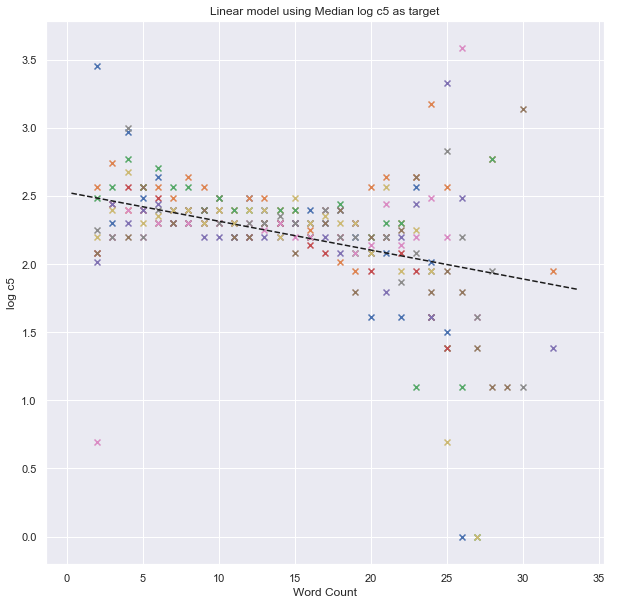

In [16]:
f = plt.figure(figsize=(10,10))
plt.scatter(x02, y02, marker="x")
plt.scatter(x03, y03, marker="x")
plt.scatter(x04, y04, marker="x")
plt.scatter(x05, y05, marker="x")
plt.scatter(x06, y06, marker="x")
plt.scatter(x07, y07, marker="x")
plt.scatter(x08, y08, marker="x")
plt.scatter(x09, y09, marker="x")
plt.scatter(x10, y10, marker="x")

plt.xlabel("Word Count")
plt.ylabel("log c5")



axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
plt.title("Linear model using Median log c5 as target")

plt.show()

Text(0.5,1,'2010 - Slope: -0.047')

<Figure size 432x288 with 0 Axes>

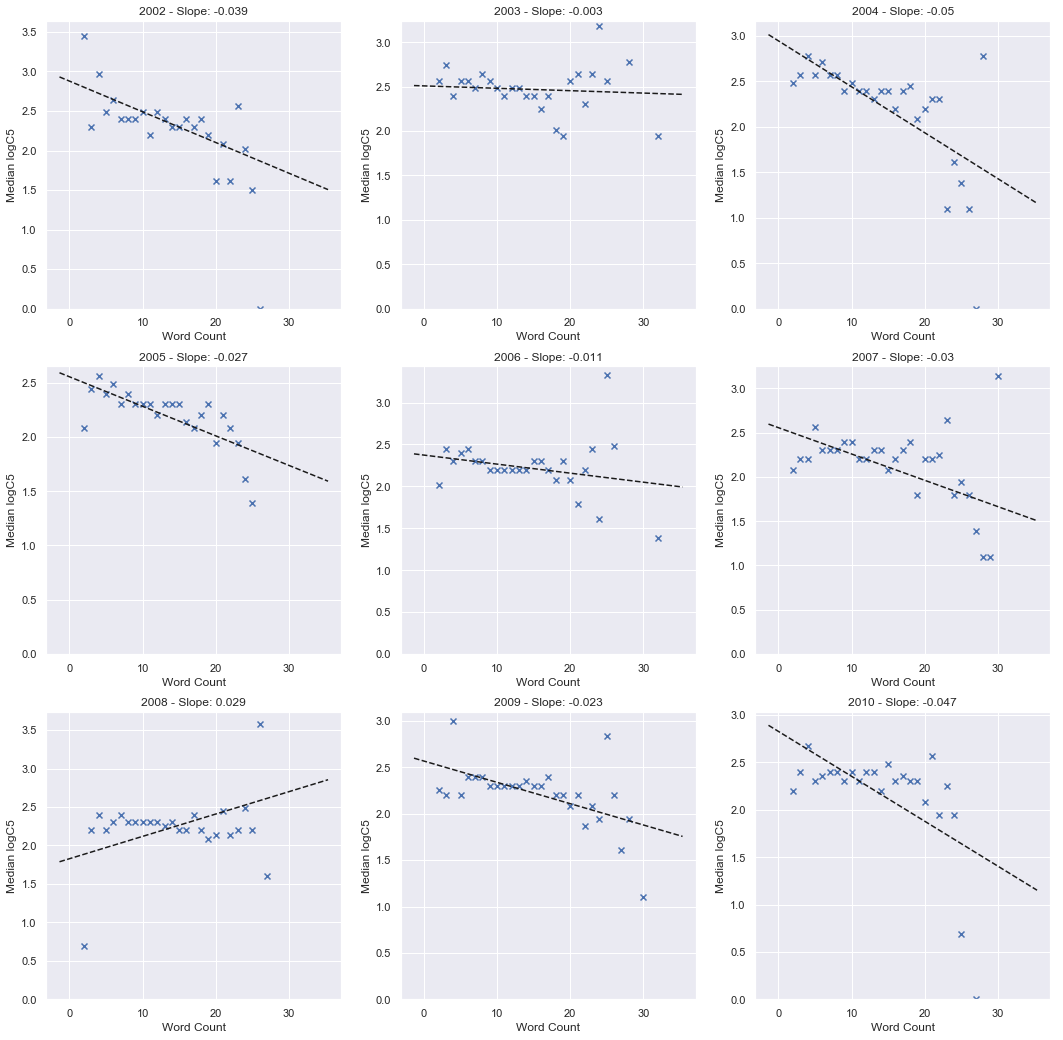

In [17]:
X_years = [x02, x03, x04, x05, x06, x07, x08, x09, x10]
y_years = [y02, y03, y04, y05, y06, y07, y08, y09, y10] 


def get_data_for_year(idx):
    X = pd.DataFrame(X_years[idx], columns=["word_count"])
    y = pd.DataFrame(y_years[idx], columns=["median_log_c5"])
    
    df = pd.concat([X, y], axis=1)
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    return df

def get_model_params(df):
    X_train, X_test, y_train, y_test = train_test_split(df[["word_count"]], df["median_log_c5"], test_size=0.1)
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)
    intercept = lm.intercept_
    slope = lm.coef_[0]

    return intercept, slope
    

# Median character, word and cleaned title word counts over the years
f1 = plt.figure()
f1 = plt.figure(figsize=(18,18))


ax1 = f1.add_subplot(331)

tmp = get_data_for_year(0)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2002 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(332)
tmp = get_data_for_year(1)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2003 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(333)
tmp = get_data_for_year(2)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2004 - Slope: " + str(np.round(slope, 3)))



ax1 = f1.add_subplot(334)
tmp = get_data_for_year(3)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2005 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(335)
tmp = get_data_for_year(4)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2006 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(336)
tmp = get_data_for_year(5)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2007 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(337)
tmp = get_data_for_year(6)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2008 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(338)
tmp = get_data_for_year(7)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2009 - Slope: " + str(np.round(slope, 3)))


ax1 = f1.add_subplot(339)
tmp = get_data_for_year(8)
intercept, slope = get_model_params(tmp)
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '--', color="k")
ax1.scatter(tmp['word_count'], 
            tmp['median_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Median logC5")
ax1.set_title("2010 - Slope: " + str(np.round(slope, 3)))     
